In [1]:
# %%capture
!unzip "/content/drive/MyDrive/dog-vision/dog-breed-identification.zip" -d"drive/MyDrive/dog-vision"

Archive:  /content/drive/MyDrive/dog-vision/dog-breed-identification.zip
replace drive/MyDrive/dog-vision/labels.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


## End to end multi class Dog classification 
This is a project to find the breed of the dog with an image of the dog
## 1. Problem
To find the breed of the dog using multi class classification models
## 2. Data 
Found on kaggle
## 3. Evaluation
Evaluation is a file with prediction probabilites for each dog breed and each test image.
## 4.Features 
 

1.   we are dealing with unstructured data in this case images.Hence best to use deep-learning
2.   we have 120 breeds of dogs, there are 10,000+ in test and training sets each
3. the ones in the test set have no labels because we will be predicting them.






# Getting our workspace ready
1.Importing tensorflow



2.Import tensorflow hub



3.Make use of GPU 

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
print("TF version", tf.__version__)
print("Hub version",hub.__version__)

## check for GPU availability
print("GPU AVAILABLE!" if tf.config.list_physical_devices("GPU") else ("GPU not available :(") )

TF version 2.8.2
Hub version 0.12.0
GPU AVAILABLE!


## Getting our data ready i.e turning into tensors, meaning matrices
we now have to convert the images to numbers, lets start by accessing and checking our data

In [ ]:
import pandas as pd
labels_csv=pd.read_csv("drive/MyDrive/dog-vision/labels.csv")
print(labels_csv.describe())


                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126


In [ ]:
labels_csv.head()


id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [ ]:
print(labels_csv.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB
None


In [ ]:
##we have 10222 entries, it may include repeated names of breed, now let us take a look at howmnay images are there for each dog breed

In [ ]:
labels_csv["breed"].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

In [ ]:
labels_csv["breed"].value_counts().min()

66

In [ ]:
labels_csv["breed"].value_counts().max()

126

In [ ]:
## we can see that the briard and eskimo_dog have the least number of 
## scottish_deerhound has 126 images
## according to the numbers we should have an easy match for scottish_deerhound,
##but let us see how this goes :)

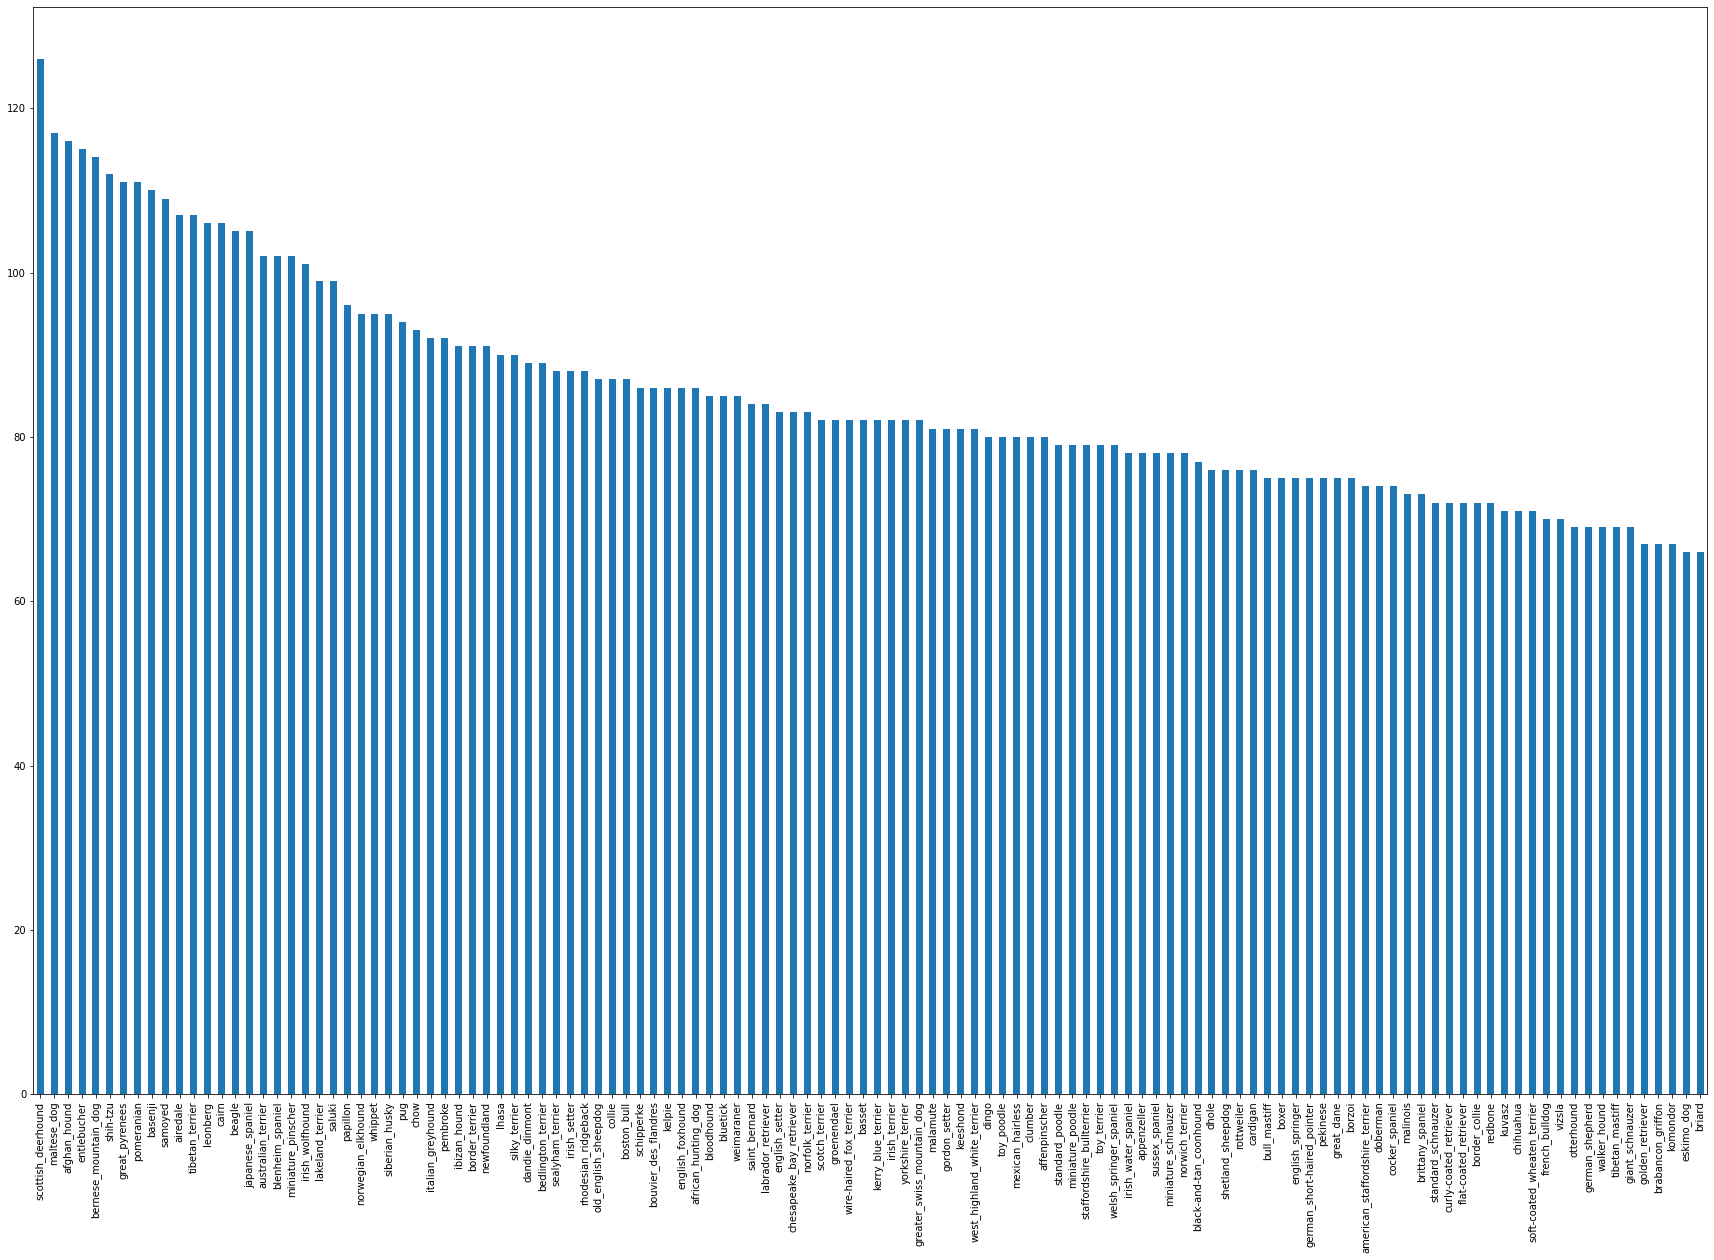

In [ ]:
labels_csv["breed"].value_counts().plot.bar(figsize=(30,20));

In [ ]:
labels_csv["breed"].value_counts().mean()

85.18333333333334

In [ ]:
labels_csv["breed"].value_counts().median()

82.0

In [ ]:
## google auto ML documentaion reccomends 100 images for each class, but minimum should be 10

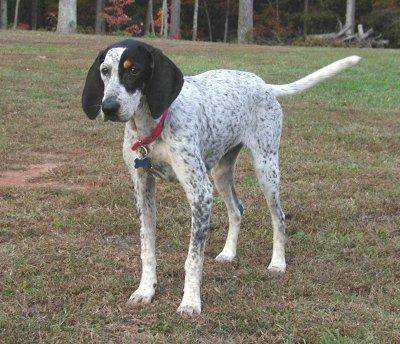

In [ ]:
#viewing an image
from IPython.display import Image
Image("drive/MyDrive/dog-vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg")

In [ ]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [ ]:
## we will create pathnames for image ID's

In [ ]:
filenames=["drive/MyDrive/dog-vision/train/"+fname+".jpg" for fname in labels_csv["id"]]
filenames[:10]

['drive/MyDrive/dog-vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/dog-vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/dog-vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/dog-vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/dog-vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/dog-vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/dog-vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/dog-vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/dog-vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/dog-vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [ ]:
## lets check whetther the number of filenames matches the number of images
import os
os.listdir("drive/MyDrive/dog-vision/train/")[:10]

['e7ab11f849e895ced3cdddf4d90e5bd2.jpg',
 'e7ab74acdc860dfb93271901da085ffd.jpg',
 'e7af30693df78697b8541fb5e2e46941.jpg',
 'e7af8f590b4fbdca0779f5e606ef91a1.jpg',
 'e7bc17ef352ef576b73467ebe9a407f1.jpg',
 'e7c5692d044250d303a839d989132bf1.jpg',
 'e7f2f67cb616281a89fc77a6bdea6eb0.jpg',
 'e7f3274adaad369068602a422e9df192.jpg',
 'e7f491cb903ff0a294eb63c625ef090e.jpg',
 'e7f4f3c25291884f2dfe7c60051d6949.jpg']

In [ ]:
import os
if len(os.listdir("drive/MyDrive/dog-vision/train/"))==len(filenames):
  print("the filenames match the number of images you can proceed!")
else:
  print("File name do not match,check the target directory")

the filenames match the number of images you can proceed!


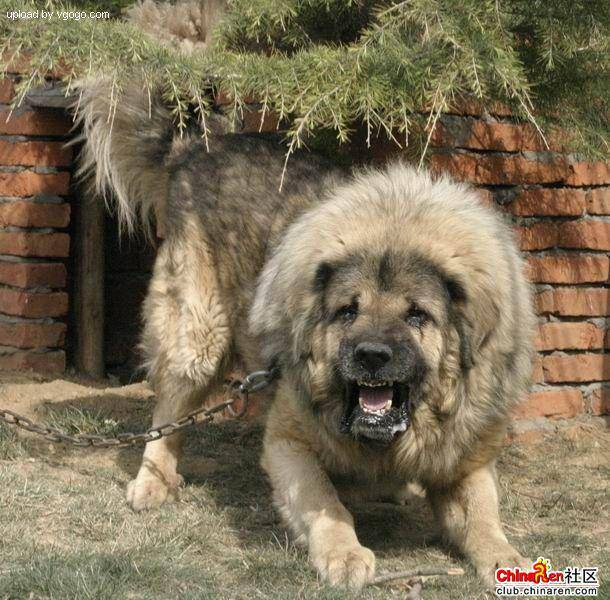

In [ ]:
## thisis how you view these beautiful creatures : )
## the next cell shows how you can get to know there breed manually
Image(filenames[9000])

In [ ]:
labels_csv["breed"][9000]

'tibetan_mastiff'

In [ ]:
## we have got our trainng image filepath in a list, we can now prepare our labels
import numpy as np
labels=np.array(labels_csv["breed"])
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [ ]:
len(labels)

10222

In [ ]:
##see if number of labels match number of filenames(filenames in basically a list of all image's file path )
if len(labels)==len(filenames):
  print("number of labels matches number of filenames!")
else:
  print("number of label does not match the filenames, check directories!")

number of labels matches number of filenames!


In [ ]:
## now we have to find unique labels so as to get them into numbers(because remember computers dont understand those breed names!)
unique_breeds=np.unique(labels)
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [ ]:
len(unique_breeds)

120

In [ ]:
##turn a single label into an array of booleans
print(labels[0])
labels[0]==unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [ ]:
## we can see that only boston bull is unique
## we will turn every label into boolean array
%%capture
boolean_array=[label==unique_breeds for label in labels]
boolean_array

In [ ]:
## we have turned every "label" in the labels list into array so that we can convert them into numbers

In [ ]:
##turning booleans into integers
print(labels[0])
print(np.where(unique_breeds==labels[0]))
print(boolean_array[0].argmax())#index in where label occurs in boolean array
print(boolean_array[0].astype(int))#there will be a 1 where sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [ ]:
print(labels[199])
print(np.where(unique_breeds==labels[2]))
print(boolean_array[199].argmax())#index in where label occurs in boolean array
print(boolean_array[199].astype(int))

malinois
(array([85]),)
72
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


## creating validation set
dataset from kaggle doesnt come with a validation set, so we have to create our own


In [ ]:
#setup X and y
X=filenames
y=boolean_array
## we will start off with 1000 images and move upward from there


In [ ]:
#set number of images to use for experimenting
NUM_IMAGES=1000 #@param{type:"slider",min:1000,max:10000,step:1000}

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val=train_test_split(X[:NUM_IMAGES],
                                             y[:NUM_IMAGES],
                                             test_size=0.2,
                                             random_state=42) ##random state is same as randomseed
##it is a good habit to check the length of the variables so as not to get in trouble while using them

len(X_train),len(y_train),len(X_val),len(y_val)

(800, 800, 200, 200)

In [ ]:
##lets look at the training data
X_train[:2],y_train[:2]

(['drive/MyDrive/dog-vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/MyDrive/dog-vision/train/0d2f9e12a2611d911d91a339074c8154.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, Fal

In [ ]:
 #to make sure training and validation sets are different
 (X_val[:2],y_val[:2])==(X_train[:2],y_train[:2])

False

In [ ]:
##NOW WE WILL BE TURNING IMAGES INTO TENSORS-Preprocessing images

## Preprocessing images

In [ ]:
## we will use functions unlike the EDA part, cause we might need to reuse codes, no I am not lazy XD

 
To preprocess our images into Tensors we're going to write a function that does few things

1. Take an image filepath as input
2. Use TensorFlow to read the file and save to a variable, "image"

3. Turn our "image"(jpg or any format for that matter) into Tensors
4.Normalize image from (0,255) to(0,1)
5. Resize the "image" to be shape of (224,224), the number is arbitary feel free to choose 420 ;)

6. Return the modified "image"

In [ ]:
## let us see how we can import an image
from matplotlib.pyplot import imread
image=imread(filenames[42]) #3filenames is list of filepath to our images
image.shape #height,width,color channel

(257, 350, 3)

In [ ]:
image.min(),image.max()#ranges from 0 to 255 are the color values


(0, 255)

In [ ]:
tf.constant(image)[:2]#image into tensor

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)>

In [ ]:
tf.constant(image)[:2]==image[:2]## its now in tensors which makes it possible for the GPU to compute nut in its true essence it is still an ndarray

<tf.Tensor: shape=(2, 350, 3), dtype=bool, numpy=
array([[[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]]])>

In [ ]:
# Define image size
IMG_SIZE=224 #we choose 224 because we want the model to have a universal shape when being trained and tested
#create a function to preprocess
def process_image(image_path):
  image=tf.io.read_file(image_path)
#turn image into numerical tensor with red,green,blue
  image=tf.image.decode_jpeg(image,channels=3)
# convert the colour channel 0-255 to 0-1, this is Normalisation! finally math is used XD
  image=tf.image.convert_image_dtype(image,tf.float32)
#resize the image to desired value
  image=tf.image.resize(image,size=[IMG_SIZE,IMG_SIZE])

  return image

In [ ]:
## the above function basically does this
#we can try each function used above seperately
%%capture
tensor=tf.io.read_file(filenames[26])
tensor

In [ ]:
## we now batch the data, we use Yann Lecun's batch size i.e 32

In [ ]:
## Why we batch data?
## I am glad you asked :) We batch data because processing 10,000+ images in one go will create a starin on the memory and it might not even fit into it.
## we use the standard practice of making the batch size 32. in order to use tensorflow effictively, we need our data in form of tuple, which look like this:
## '(image,label)'
def get_image_label(image_path,label):
  image= process_image(image_path)
  return image,label


In [ ]:
(process_image(X[42]),y[42])

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

In [ ]:
## we can seee the labels are not in tensor so we will use tf.constant

In [ ]:
(process_image(X[42]),tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

In [ ]:
## now that we have labels in tensors we need to turn them into batches of 32!

In [ ]:
# Define the batch size, 32 is a good default
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (x) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle it if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # only filepaths
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch
  
  # If the data if a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    # If the data is a training dataset, we shuffle it
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                              tf.constant(y))) # labels
    
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(x))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [ ]:
training_data=create_data_batches(X_train,y_train)
val_data=create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [ ]:
#let us check attributes of our data batches
training_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

In [ ]:
## now that was a lot to understand, so let us visualize the batches, since batches can be hard to comprehend, even for me :)
import matplotlib.pyplot as plt

def show_25_images(images,labels):
  plt.figure(figsize=(15,15))
  for i in range(25):
    ax=plt.subplot(5,5,i+1)
    plt.imshow(images[i])
    plt.title(unique_breeds[labels[i].argmax()])
    plt.axis("Off")


In [ ]:
train_images,train_labels=next(training_data.as_numpy_iterator())

In [ ]:
%%capture
train_images,train_labels

In [ ]:
len(train_images),len(train_labels)

(32, 32)

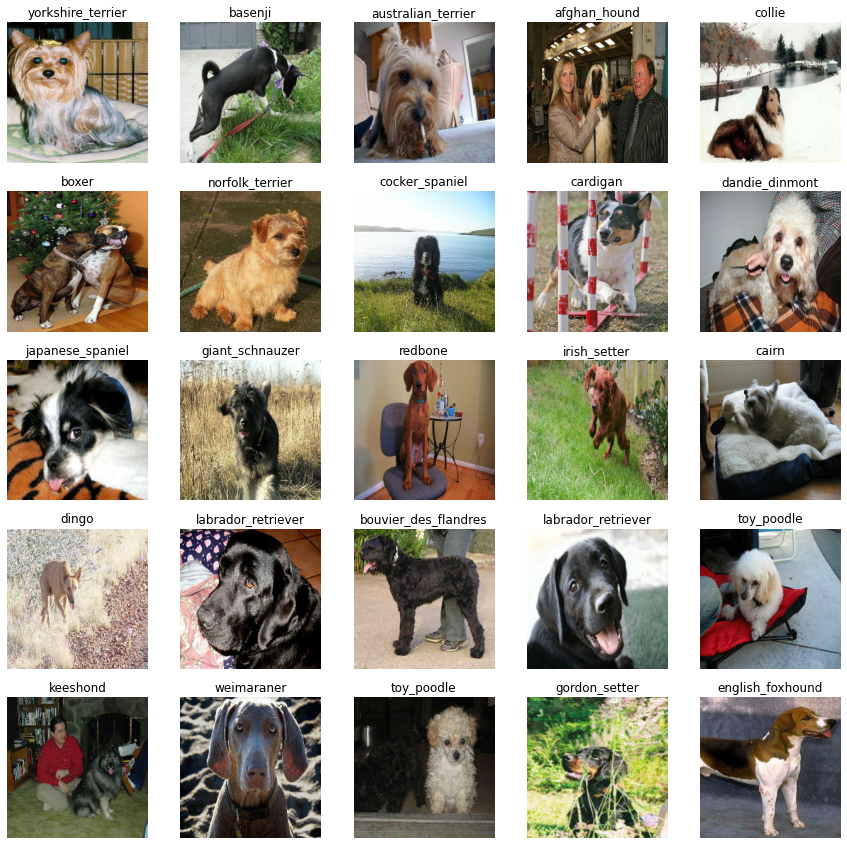

In [ ]:
show_25_images(train_images,train_labels)

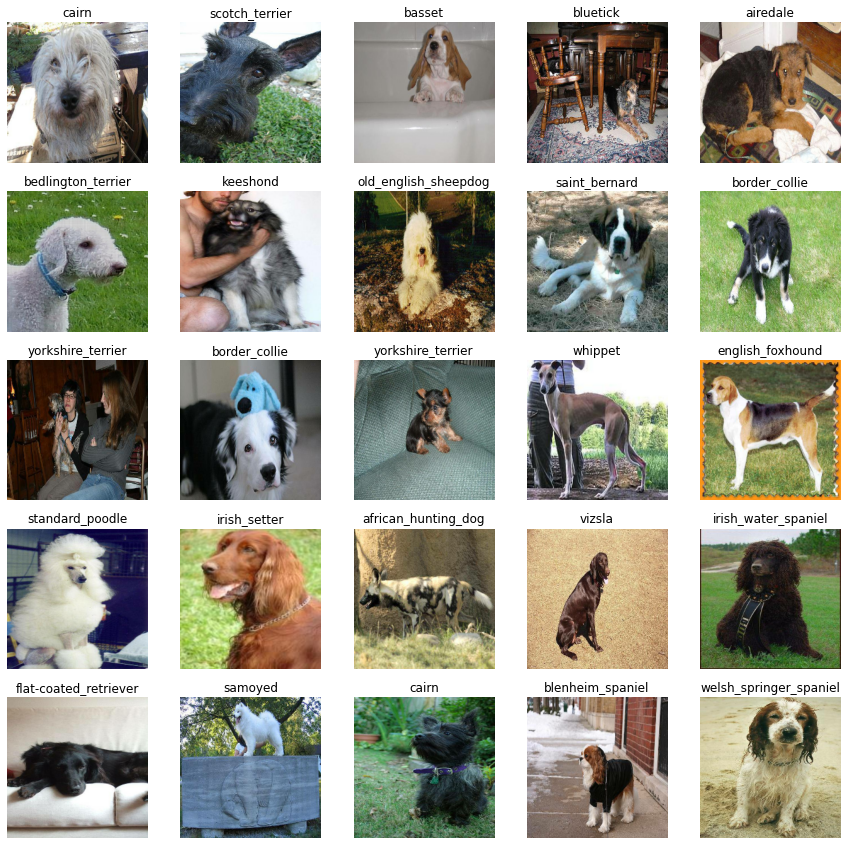

In [ ]:
#validation set
val_images,val_labels=next(val_data.as_numpy_iterator())
show_25_images(val_images,val_labels)

## building a model
##Before we build a model, there are a few things we need to define:
 * the input shape
 * the output shape
 * the URL of the model we wnat to use 
 
 

In [ ]:
#setup input shape to the model
INPUT_SHAPE=[None,IMG_SIZE,IMG_SIZE,3]
#output shape
OUTPUT_SHAPE=len(unique_breeds)
MODEL_URL="https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

In [ ]:
## we will use keras API and we will be using sequential API
## now we have input,outputs and model ready to go! let us put them into keras deep learning model

 we will create a function that does the following:
 * take sinput shape, output shape and the model we have choosen as parameters.
 * defines the layers in a keras model in sequential fashion
 * compiles the model (says it should be evaluated and improved)
 * building the model
 *returns the model

In [ ]:
def create_model(input_shape=INPUT_SHAPE,output_shape=OUTPUT_SHAPE,model_url=MODEL_URL):
  print("building model with:",MODEL_URL)
  #set up the model layers
  model=tf.keras.Sequential([
                             hub.KerasLayer(MODEL_URL),#input layer-layer1
                             tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                                                   activation="softmax")#output layer-layer2
  ])
  #compile the model:reducing the loss, pre requisite: loss function
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )
  # build the model
  model.build(INPUT_SHAPE)
  return model

In [ ]:
model=create_model()
model.summary()

building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_4 (KerasLayer)  (None, 1001)              5432713   
                                                                 
 dense_4 (Dense)             (None, 120)               120240    
                                                                 
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


## Callbacks
Creating callbacks:
We've got a model ready to go but before we train it we'll make some callbacks.

Callbacks are helper functions a model can use during training to do things such as save a models progress, check a models progress or stop training early if a model stops improving.

The two callbacks we're going to add are a TensorBoard callback and an Early Stopping callback.

TensorBoard Callback
TensorBoard helps provide a visual way to monitor the progress of your model during and after training.

It can be used directly in a notebook to track the performance measures of a model such as loss and accuracy.

To set up a TensorBoard callback and view TensorBoard in a notebook, we need to do three things:

Load the TensorBoard notebook extension.
Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's fit() function.
Visualize the our models training logs using the %tensorboard magic function (we'll do this later on).



In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("drive/My Drive/Data/logs",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

In [ ]:
## Early stopping call backs
##helps stop our model from overfitting

In [ ]:
# Create early stopping (once our model stops improving, stop training)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3) # stops after 3 rounds of no improvements

In [ ]:
# Check again if GPU is available (otherwise computing will take a looooonnnnggggg time)
print("GPU", "available (YESS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

GPU available (YESS!!!!)


In [ ]:
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

In [ ]:
# Build a function to train and return a trained model
def train_model():
  # Create a model
  model = create_model()

  # Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x=training_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1, # check validation metrics every epoch
            callbacks=[tensorboard, early_stopping])
  
  return model

In [ ]:
model = train_model()

building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100
25/25 [==============================] - 16s 398ms/step - loss: 4.5801 - accuracy: 0.0862 - val_loss: 3.4747 - val_accuracy: 0.2350
Epoch 2/100
25/25 [==============================] - 4s 161ms/step - loss: 1.6495 - accuracy: 0.6725 - val_loss: 2.2307 - val_accuracy: 0.4950
Epoch 3/100
25/25 [==============================] - 4s 142ms/step - loss: 0.5773 - accuracy: 0.9388 - val_loss: 1.6880 - val_accuracy: 0.5750
Epoch 4/100
25/25 [==============================] - 4s 142ms/step - loss: 0.2559 - accuracy: 0.9875 - val_loss: 1.5004 - val_accuracy: 0.6100
Epoch 5/100
25/25 [==============================] - 4s 157ms/step - loss: 0.1484 - accuracy: 0.9962 - val_loss: 1.4176 - val_accuracy: 0.6450
Epoch 6/100
25/25 [==============================] - 4s 154ms/step - loss: 0.1003 - accuracy: 1.0000 - val_loss: 1.3728 - val_accuracy: 0.6550
Epoch 7/100
25/25 [=============================

In [ ]:
predictions = model.predict(val_data, verbose=1) # verbose shows us how long there is to go
predictions

7/7 [==============================] - 1s 98ms/step


array([[3.48476839e-04, 1.77829806e-05, 1.31959596e-03, ...,
        4.19503078e-04, 1.22463025e-04, 2.52393051e-03],
       [8.93400982e-04, 3.99267767e-04, 9.25734546e-03, ...,
        8.37694446e-04, 7.91480648e-04, 1.83380500e-04],
       [1.77956535e-05, 3.62806517e-04, 1.01246627e-03, ...,
        2.54368351e-04, 2.72661309e-05, 9.25217028e-05],
       ...,
       [5.81009808e-05, 5.17367676e-04, 1.95979592e-04, ...,
        7.28730811e-05, 5.85334492e-05, 8.21253852e-05],
       [9.19405837e-03, 2.58546526e-04, 1.11428926e-04, ...,
        9.11696843e-05, 1.58475930e-04, 2.35168301e-02],
       [1.06433104e-03, 4.86058816e-05, 1.11811841e-02, ...,
        1.10394042e-02, 1.54429779e-03, 1.07705513e-04]], dtype=float32)

In [ ]:
print(predictions[0])
print(f"Max value (probability of prediction): {np.max(predictions[0])}") # the max probability value predicted by the model
print(f"Sum: {np.sum(predictions[0])}") # because we used softmax activation in our model, this will be close to 1
print(f"Max index: {np.argmax(predictions[0])}") # the index of where the max value in predictions[0] occurs
print(f"Predicted label: {unique_breeds[np.argmax(predictions[0])]}") # the predicted label

[3.48476839e-04 1.77829806e-05 1.31959596e-03 1.17213989e-04
 3.57470737e-04 1.94672612e-05 1.68853104e-02 1.32872534e-04
 6.24682361e-05 1.73052796e-03 1.66529222e-04 5.13764426e-05
 6.71909729e-05 3.69551599e-05 2.15890090e-04 1.90798732e-04
 1.56841488e-05 2.08967209e-01 2.39404817e-05 4.29229003e-05
 7.02034216e-04 1.19113894e-04 2.61161640e-05 7.88143720e-04
 4.78758702e-05 1.76007190e-04 5.07910669e-01 6.57102137e-05
 1.47345068e-04 1.44051912e-03 2.92579825e-05 6.04378060e-04
 5.41595975e-04 7.51078187e-06 6.51314258e-05 1.22638931e-02
 3.13916826e-05 2.21305920e-04 9.48800589e-05 1.06396205e-04
 1.11562794e-03 3.02342360e-05 1.14731549e-04 2.37254368e-04
 3.03043253e-05 3.89085180e-05 1.78036153e-05 8.76272752e-05
 1.34380083e-04 5.59869281e-04 1.12270835e-04 1.48984209e-05
 4.08441003e-04 4.41471493e-05 6.09910203e-05 6.15137687e-05
 5.46795054e-05 7.72177998e-04 9.30401264e-04 3.93226072e-02
 1.46738006e-04 4.21955847e-05 2.72840000e-04 3.40543666e-05
 2.75348226e-04 8.105996

In [ ]:
def get_pred_label(prediction_probabilities):
 
  return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[0])
pred_label

'cairn'

In [ ]:
def unbatchify(data):
  images = []
  labels = []
  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.2770141 , 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

In [ ]:
def plot_pred(prediction_probabilities, labels, images, n=11):
  """
  View the prediction, ground truth label and image for sample n.
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]
  
  # Get the pred label
  pred_label = get_pred_label(pred_prob)
  
  # Plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the color of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  plt.title("{} {:2.0f}% ({})".format(pred_label,
                                      np.max(pred_prob)*100,
                                      true_label),
                                      color=color)

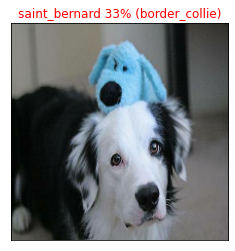

In [ ]:
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images)

In [ ]:
def plot_pred_conf(prediction_probabilities, labels, n=11):
 

  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]                                 
  # Find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)), 
                     top_10_pred_values, 
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")

  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

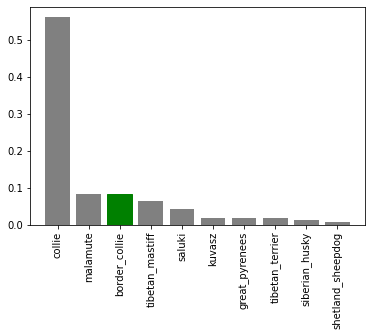

In [ ]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=9)

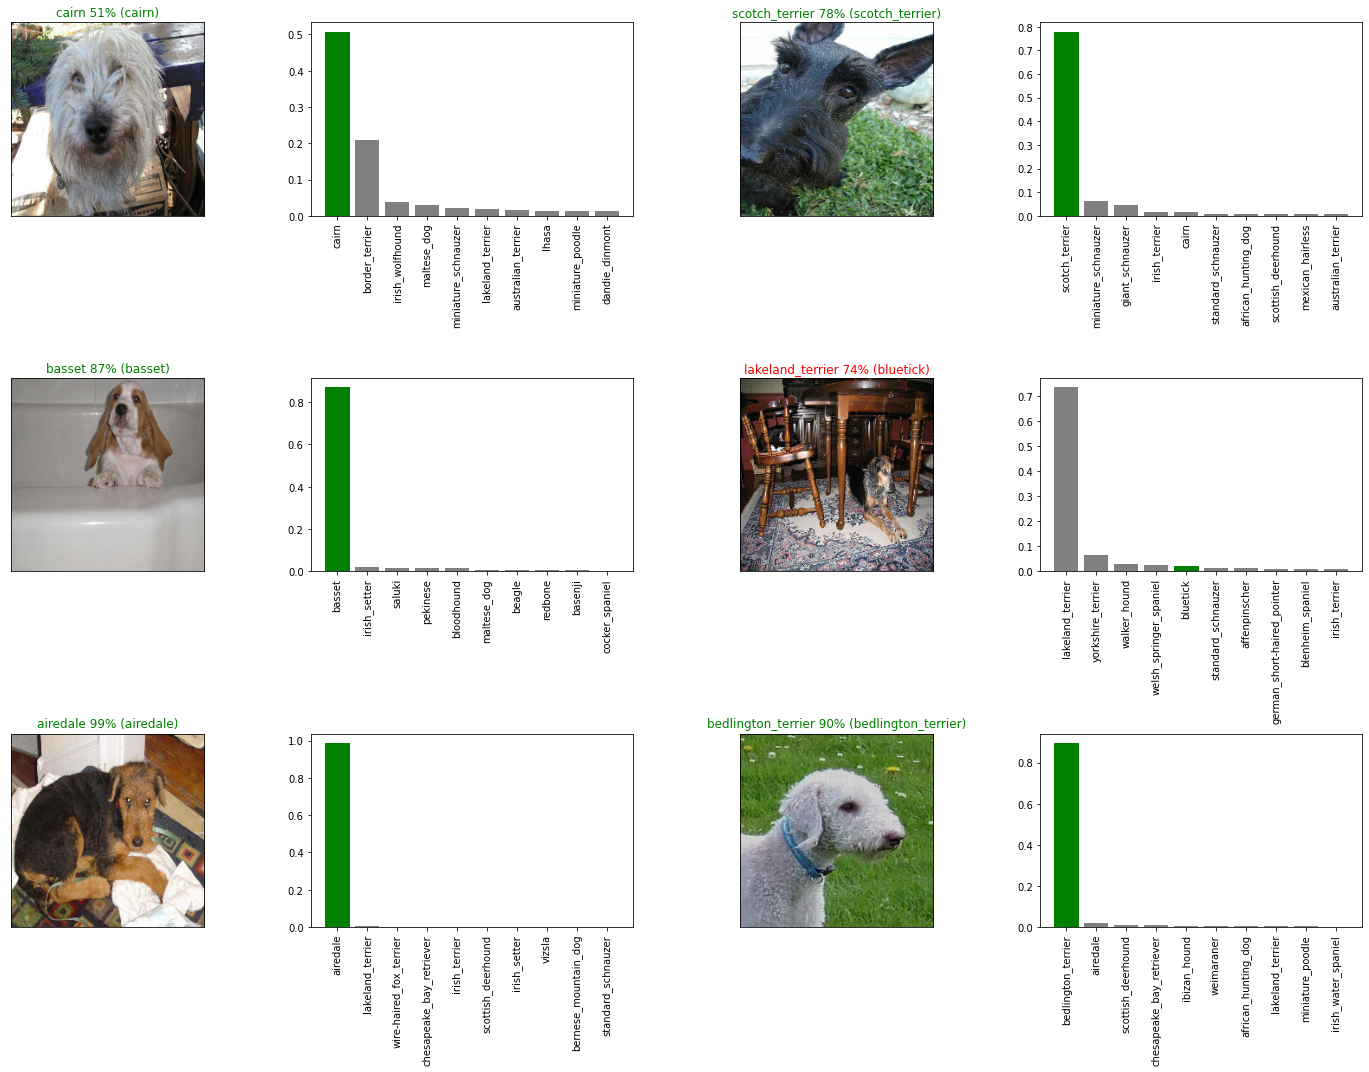

In [ ]:
i_multiplier = 0
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(5*2*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                labels=val_labels,
                n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

In [ ]:
custom_path="drive/MyDrive/dog-vision/my-dog-images/"

In [ ]:
custom_image_path=[custom_path+fname for fname in os.listdir(custom_path)]

In [ ]:
custom_image_path

['drive/MyDrive/dog-vision/my-dog-images/dog1.jfif',
 'drive/MyDrive/dog-vision/my-dog-images/dog2.jfif',
 'drive/MyDrive/dog-vision/my-dog-images/dog3.jpg',
 'drive/MyDrive/dog-vision/my-dog-images/dog4.jfif',
 'drive/MyDrive/dog-vision/my-dog-images/dog6.jfif',
 'drive/MyDrive/dog-vision/my-dog-images/dogpic.jfif',
 'drive/MyDrive/dog-vision/my-dog-images/scooby.jfif']

In [ ]:
custom_data=create_data_batches(custom_image_path,test_data=True)
custom_data

Creating test data batches...


<BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [ ]:
custom_preds = model.predict(custom_data)
custom_preds.shape

(7, 120)

In [ ]:
custom_pred_labels=[get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]

In [ ]:
custom_pred_labels

['newfoundland',
 'whippet',
 'siberian_husky',
 'yorkshire_terrier',
 'black-and-tan_coonhound',
 'english_foxhound',
 'standard_poodle']

In [ ]:
custom_images=[]
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

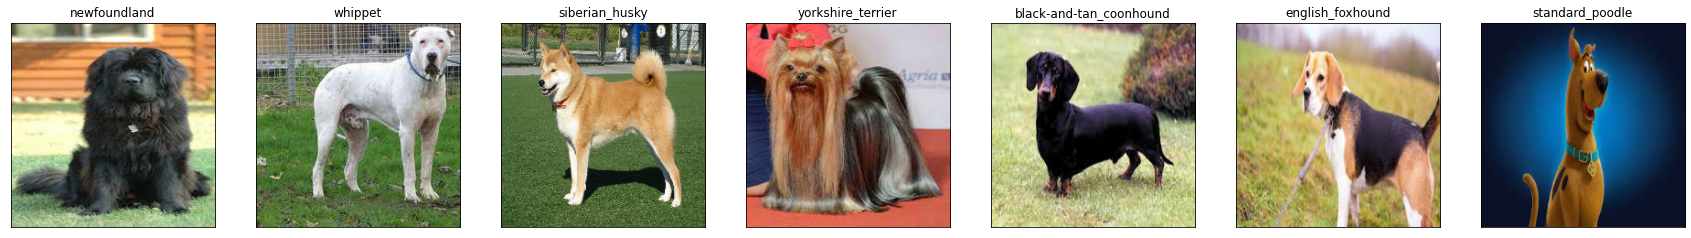

In [ ]:
plt.figure(figsize=(30, 30))
for i, image in enumerate(custom_images):
  plt.subplot(1, 7, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image);